## Kernel Ridge Regression comparison between Shogun and Sklearn.

We will do a comparison between Shogun's and OpenCV's KRR implementations using a standard regression data-set available [here](https://www.kaggle.com/new-york-city/nyc-property-sales). Our dataset consists of 84548 examples in which we will use "m" examples which will be increased progressively. 

### Note
Due to memory restriction we shall only be working with at max m = 10000 examples

Let's start with the imports!

In [1]:
# NUMPY & PANDAS
import numpy as np
import pandas as pd

# MATPLOTLIB
import matplotlib.pyplot as plt

# SCIKIT LEARN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data reading
import io
import requests
url="https://raw.githubusercontent.com/NanuSai/shogun-benchmarks/master/data/nyc-sales.csv"


# SHOGUN
from shogun import *

from time import time

### Read the CSV File 
Let's explore the dataset and see it's components.

In [2]:
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


### Data preprocessing

We will be applying regression on the column `SALE PRICE`. 

The data preprocessing will be done in three steps

1. Separate data to training and test
2. Encode Categorical Variables using LabelEncoding
3. Convert features and labels to Shogun Friendly form

#### Separate train and test

In the dataset empty values of `SALE PRICE` is set `-` we need to fill it with ```np.nan```.

In [3]:
def replace_with_nan(df):
    for i in range(len(df)):
        if(df.loc[i,'SALE PRICE'] == ' -  '):
            df.at[i,'SALE PRICE'] = np.nan
    return df  

Next we need to separate filter our dataframe based on the value of `SALE PRICE`. We will filter out all the data with `np.nan` and use the remaining data for train and validation purpose.

In [4]:
def filter_data(df):
    
       
    #train is the cleaned data
    df_train = df[df['SALE PRICE'].notna()]
    # Separate target var
    col_x = [col for col in df.columns
          if col != 'SALE PRICE']

    X = df_train[col_x] #Training set

    # target variable
    target = ['SALE PRICE']

    y= df_train[target] #Training targets
    
    return X,y

#### Label encoding

We first need to identify all the categorical categorical form of data and then convert them into encoded form

In [5]:
def label_encode(X):
    encoder = LabelEncoder()
    
    #cat_vars have all categorical variable name
    s = (X.dtypes == 'object')
    cat_vars = list(s[s].index)

    # drop the unwanted columns
    X = X.drop(columns=['Unnamed: 0','NEIGHBORHOOD','ADDRESS','EASE-MENT',
                                  'BUILDING CLASS CATEGORY','SALE DATE','APARTMENT NUMBER'])

    
    #Recheck if any categorical variable remaining.
    s = (X.dtypes == 'object')
    cat_varsx = list(s[s].index)

    #  Labeling properly the columns with object data type
    le = LabelEncoder()

    num_X= X.copy()
    for col in cat_varsx:
        num_X[col] = le.fit_transform(X[col])
        
    return num_X    

#### Convert feature to shogun friendly form

Now we need to convert pandas to numpy form and reshape label column so that shogun may process them.

In [6]:
def process_data(num_X,y):
    num_X= num_X.to_numpy().astype(float)  
    y= y.to_numpy().astype(float)
    y= y.reshape(y.shape[0],) #reshape to (num_samples,)
    
    return num_X,y

In [7]:
#Data Preprocessing

df = replace_with_nan(df)        
X,y = filter_data(df)
num_X= label_encode(X)
num_X,y = process_data(num_X,y)

#Split data
X_train, X_test, y_train, y_test = train_test_split(num_X, y, test_size=0.33, random_state=42)



In [8]:
#Parameters for plotting
time_skl = []
time_sgn = []
time_diff = []
size = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
error_skl=[]
error_sgn=[]

## Training

As noted above we will only use at max 10000 examples and see how it predicts on the entire test set. The result will be graphed. We're using RMSE as our error metric.

In [9]:

for m in size:
    
    print(m)

#SKLEARN

    X_train_temp = X_train[:m]
    y_train_temp = y_train[:m]
    skr = KernelRidge(kernel='rbf', gamma=0.1)

    t0 = time()
    skr.fit(X_train_temp, y_train_temp)
    tsk1 = time() - t0

    #Apply to test set
    y_predict = skr.predict(X_test) #Predict on the entire test set
    err_skl = mean_squared_error(y_test,y_predict,squared=False)
    error_skl.append(err_skl) #Get error and append to list
    

    time_skl.append(tsk1) 


#SHOGUN        
    train_features = features(X_train_temp.T)
    labels_train = RegressionLabels(y_train_temp)

    width = 0.0
    gaussian_kernel =  kernel("GaussianKernel", log_width=width)
    gaussian_kernel.init(train_features, train_features)
    krr = machine("KernelRidgeRegression", labels=labels_train, tau=0.001, kernel=gaussian_kernel)

    t0=time()
    krr.train()
    tsg1=time()-t0

    #Apply to test set
    labels_predict = krr.apply_regression(features(X_test.T))
    err_sgn = mean_squared_error(y_test,labels_predict.get_labels(),squared=False)
    error_sgn.append(err_sgn) #get error and append to list
    

    time_sgn.append(tsg1)
   
    
    
    print("Sklearn time: " + str(tsk1))
    print("Shogun time: " + str(tsg1))
    print("SKL Error: " + str(err_skl))
    print("Shogun Error: " + str(err_sgn))
    print("\n")


1000
Sklearn time: 0.698040246963501
Shogun time: 0.2183237075805664
SKL Error: 15571108.076778537
Shogun Error: 15571979.03746738


2000
Sklearn time: 0.2946889400482178
Shogun time: 0.6580216884613037
SKL Error: 15567980.831106262
Shogun Error: 15570325.064430282


3000
Sklearn time: 0.6815590858459473
Shogun time: 1.6444525718688965
SKL Error: 15567344.50320614
Shogun Error: 15569939.408445997


4000
Sklearn time: 0.8942825794219971
Shogun time: 2.638134002685547
SKL Error: 15564029.258770406
Shogun Error: 15568233.05902467


5000
Sklearn time: 1.4050970077514648
Shogun time: 3.9994306564331055
SKL Error: 15561470.017019505
Shogun Error: 15567445.06697485


6000
Sklearn time: 2.0812904834747314
Shogun time: 6.179321050643921
SKL Error: 15558712.483802943
Shogun Error: 15566123.4555562


7000
Sklearn time: 2.9170913696289062
Shogun time: 10.093526124954224
SKL Error: 15558490.30669556
Shogun Error: 15567124.151350742


8000
Sklearn time: 5.2164411544799805
Shogun time: 11.28917217254

#### NOTE
Both Shogun and Sklearn **perform poorly** because the number of training samples feeded to the machine is very less (10000) compared to the actual given (nearly 80000).Increasing number of samples used by more than 20k will cause `MemoryError` in most computer as it involves inversion of which costs nearly $\mathcal{O(m^2)}$ or worse where `m=Number of samples`


## Plotting 

The below graph will plot KRR Computation time and Error RMSE plot for Shogun and SKLearn. Let's see the plot.

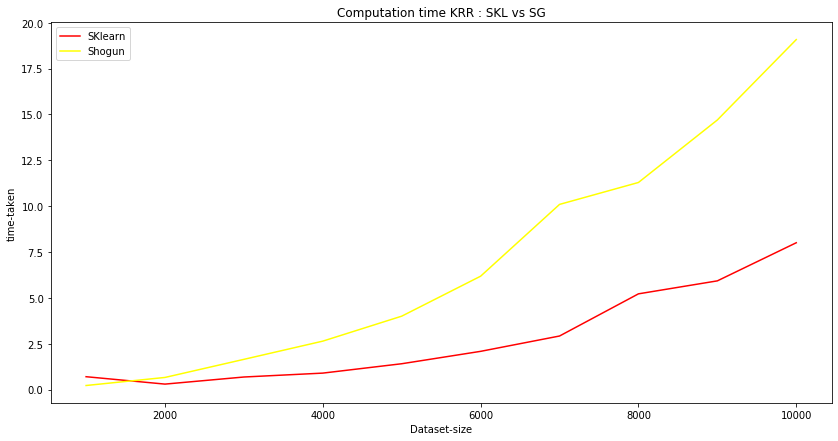

In [10]:
# PLOTTING Time_taken
plt.figure(figsize=(14,7))
plt.title('Computation time KRR : SKL vs SG')
plt.plot(size,time_skl,color='red',label='SKlearn')
plt.plot(size,time_sgn,color='yellow',label='Shogun')
plt.xlabel('Dataset-size')
plt.ylabel('time-taken')
plt.legend()

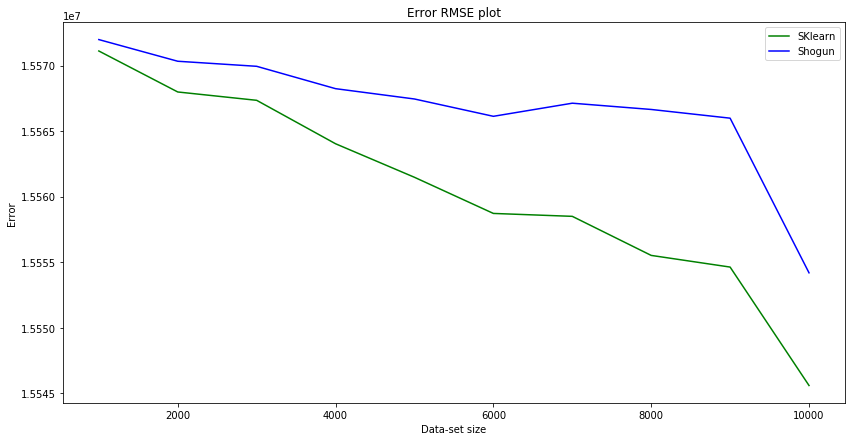

In [11]:
# PLOTTING Error
plt.figure(figsize=(14,7))
plt.title('Error RMSE plot')
plt.plot(size,error_skl,color='green',label='SKlearn')
plt.plot(size,error_sgn,color='blue',label='Shogun')
plt.xlabel('Data-set size')
plt.ylabel('Error')
plt.legend()